# *****************************  BT Notebook Copy  *************************************

# Intro to Machine Learning with Tensorflow Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the first project of the Data Scientist Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
#Added this code block to turn off depreciation warnings, as they detract from the Aesthetics of the Notebook.
import warnings
warnings.filterwarnings('ignore')

## Import of necessary packages

In [2]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score
from IPython.display import display # Allows the use of display() for DataFrames

## Inclusion of relevent 'visuals.py' functions {distribution, evaluate, feature_plot} to make this a stand alone Notebook

In [3]:
def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = pl.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['capital-gain','capital-loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()


def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (12,10))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.show()
    

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  


In [4]:
# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [5]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data.income == '>50K'].shape[0]
# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data.income == '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.3%}%".format(greater_percent)) #5 sig figs.

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.784%%


In [6]:
#Two native countries in the dataset are 'South' and 'Hong'.  Not materially important for the analysis but of note.
col = 'native-country'
print(','.join(str(x) for x in (data[col].unique())))
print('\n',len(data[col].unique()))

 United-States, Cuba, Jamaica, India, Mexico, Puerto-Rico, Honduras, England, Canada, Germany, Iran, Philippines, Poland, Columbia, Cambodia, Thailand, Ecuador, Laos, Taiwan, Haiti, Portugal, Dominican-Republic, El-Salvador, France, Guatemala, Italy, China, South, Japan, Yugoslavia, Peru, Outlying-US(Guam-USVI-etc), Scotland, Trinadad&Tobago, Greece, Nicaragua, Vietnam, Hong, Ireland, Hungary, Holand-Netherlands

 41


** Featureset Exploration **  (added number of discrete categories to each categorical data header)

* **age**: _**continuous.**_ 
* **workclass(7)**: State-gov, Self-emp-not-inc, Private, Federal-gov, Local-gov, Self-emp-inc, Without-pay
* **education_level(16)**: Bachelors, HS-grad, 11th, Masters, 9th, Some-college, Assoc-acdm, 7th-8th, Doctorate, Assoc-voc, Prof-school, 5th-6th, 10th, Preschool, 12th, 1st-4th.
* **education-num**: _**continuous.**_ 
* **marital-status(7)**: Never-married, Married-civ-spouse, Divorced, Married-spouse-absent, Separated, Married-AF-spouse, Widowed.
* **occupation(14)**: Adm-clerical, Exec-managerial, Handlers-cleaners, Prof-specialty, Other-service, Sales, Transport-moving, Farming-fishing, Machine-op-inspct, Tech-support, Craft-repair, Protective-serv, Armed-Forces, Priv-house-serv.
* **relationship(6)**: Not-in-family, Husband, Wife, Own-child, Unmarried, Other-relative. 
* **race(5)**: White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo, Other.
* **sex(2)**: Female, Male. 
* **capital-gain**: _**continuous.**_ 
* **capital-loss**: _**continuous.**_ 
* **hours-per-week**: _**continuous.**_ 
* **native-country(41)**: United-States, Cuba, Jamaica, India, Mexico, Puerto-Rico, Honduras, England, Canada, Germany, Iran, Philippines, Poland, Columbia, Cambodia, Thailand, Ecuador, Laos, Taiwan, Haiti, Portugal, Dominican-Republic, El-Salvador, France, Guatemala, Italy, China, South, Japan, Yugoslavia, Peru, Outlying-US(Guam-USVI-etc), Scotland, Trinadad&Tobago, Greece, Nicaragua, Vietnam, Hong, Ireland, Hungary, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

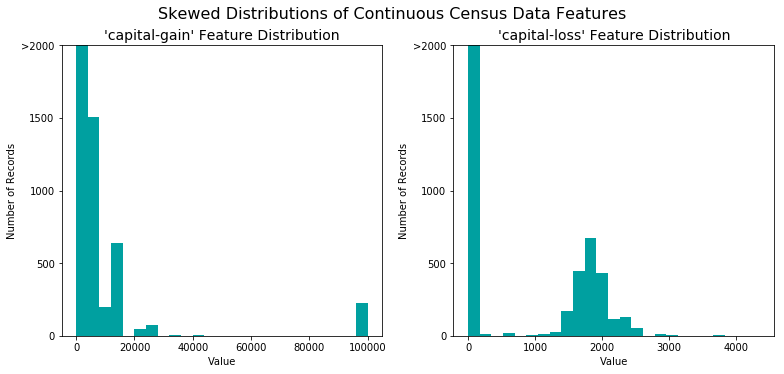

In [7]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

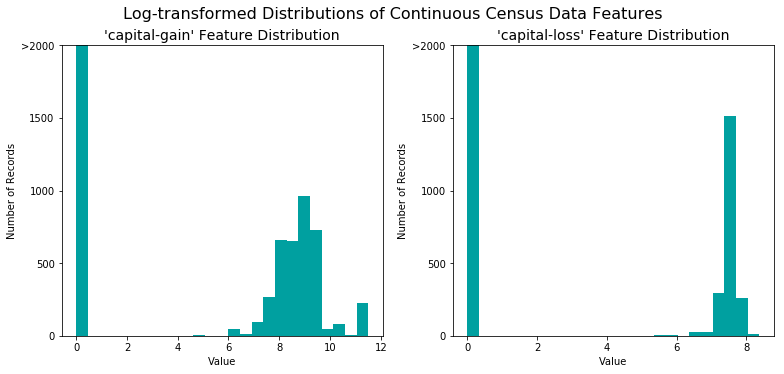

In [8]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1)) #Natural Log

# Visualize the new log distributions
distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this. (Normalizes to value between 0 and 1).

In [9]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
5,0.273973,Private,Masters,0.866667,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.000000,0.0,0.397959,United-States
6,0.438356,Private,9th,0.266667,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.000000,0.0,0.153061,Jamaica
7,0.479452,Self-emp-not-inc,HS-grad,0.533333,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.448980,United-States
8,0.191781,Private,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.829751,0.0,0.500000,United-States
9,0.342466,Private,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.742849,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [10]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
###Was - features_final = pd.get_dummies(features_log_minmax_transform, columns=['workclass','education_level','marital-status','occupation','relationship','race','native-country'])
###Is - 
features_final = pd.get_dummies(features_log_minmax_transform)

###Was - #Converts 'sex' to 0=Male, 1=Female
###Was - features_final["sex"] = np.where(features_final["sex"].str.contains("Female"), 1, 0) #1 = Female, 0 = Male
###Was - ###One hot encodes other categorical features

# TODO: Encode the 'income_raw' data to numerical values
income = pd.DataFrame(data = income_raw)
income['income'] = np.where(income_raw.str.contains(">50K"), 1, 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
for item in encoded:
    print(item)

103 total features after one-hot encoding.
age
education-num
capital-gain
capital-loss
hours-per-week
workclass_ Federal-gov
workclass_ Local-gov
workclass_ Private
workclass_ Self-emp-inc
workclass_ Self-emp-not-inc
workclass_ State-gov
workclass_ Without-pay
education_level_ 10th
education_level_ 11th
education_level_ 12th
education_level_ 1st-4th
education_level_ 5th-6th
education_level_ 7th-8th
education_level_ 9th
education_level_ Assoc-acdm
education_level_ Assoc-voc
education_level_ Bachelors
education_level_ Doctorate
education_level_ HS-grad
education_level_ Masters
education_level_ Preschool
education_level_ Prof-school
education_level_ Some-college
marital-status_ Divorced
marital-status_ Married-AF-spouse
marital-status_ Married-civ-spouse
marital-status_ Married-spouse-absent
marital-status_ Never-married
marital-status_ Separated
marital-status_ Widowed
occupation_ Adm-clerical
occupation_ Armed-Forces
occupation_ Craft-repair
occupation_ Exec-managerial
occupation_ Farmi

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [11]:
# Import train_test_split
from sklearn.model_selection import train_test_split #Cross Validation Module Depreciated

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \\$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [12]:
# TODO: Calculate accuracy, precision and recall
accuracy = (income[income['income']==1].shape[0])/(income.shape[0])
recall = (income[income['income']==1].shape[0])/((income[income['income']==1].shape[0])+(0))
precision = (income[income['income']==1].shape[0])/((income[income['income']==1].shape[0])+(income[income['income']==0].shape[0]))

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1+beta**2)*((precision*recall)/( ((beta**2)*precision)+recall))
# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

Answer:  
    I've decided to evaluate three Ensemble methods for this project.  Based on prior learning, as well as learning from this Udacity ML course it seems that Ensemble methods generally perform better than individaul models working in isolation.  This is based on "The Wisdom of Crowds" and regression to the mean.  This essentially stipulates that with many partially informed guesses, the ditribution of answers will go toward a gaussian distibution around the mean of the true answer.  Ensemble models effeectively 'take votes' from many individual models as opposed to just relying on the outcome of a single classification model.  The Ensemble models that I've chosen to evaluate initially are:

- Random Forest
    The Random Forest model is an extension of Bagging or 'Bootstrap aggregating' (which utilizes bootstrapping to create randomized samples of the data & creates a tree for each).  With Bagging, the resulting tree is then a weighted average of all the component trees.  With the Random Forest, however, the featureset is also sampled.  Generally, sqrt(total # features) works well for the number of features randomly subsetted for each tree.  Unlike a single decision tree, there is no pruning with a Random Forest so all trees are fully grown.  Essentially, the two main hyperparameters to tune are 1) The number of trees, and 2) the Number of features in each subset.  Additional Random Forest hyperparameters tend to have marginal impact on predictive accuracy (https://bradleyboehmke.github.io/HOML/random-forest.html).
    - According to techopedia.com, one example of a Random Forest model used in industry, is in prediction of Wine Quality based on factors such as acidity, sugar, SO2 levels, pH and Ethanol content.
        - A core strength of this model is simplicity of implementation.  The Random Forest model performs well out of the box becasue there are really only two significant hyperparameters (mentioned above) to tune.  Random Forests can be used for both classification and regression, and predictive run-time is fast.
        - A weakness of this model is with Regression. It cannot extraploate outside the boundaries of the training data set.  Additionally, as with all Ensembles, it is computationally expensive relative to a single classifier model.
        - The CharityML dataset contains 103 features which is a significant amount.  The Random Forest model is good at handling this level of complexity while other classifiers may not be.  The dataset also contains many binary attributes after one hot encoding, and the Random Forest model handles binary data well as it's based on decision tree splitting.
        
- Ada Boost
    AdaBoost is short for "Adaptive Boosting".  It is a Boosting algorithm becasue it learns through iteration, where only one 'weak' learner is trained per step.  Generally, AdaBoost uses decision tree 'stumps' as the weak learner(https://www.mygreatlearning.com/blog/gradient-boosting/).  A learner is weak because it is only slightly better than a naive model.  With each iteration, the resulting model error is fed forward to the next iteration, and the model weights are adjusted to favor those instances that were misclassified in the prior model.  The performance of the final model is greater than the sum of it's parts.    
    - According to a 2018 paper out of the University of China School of Communication, the AdaBoost Algorithm can be effectively used for fraud detection in the Telecommunications industry.
    - A strenght of AdaBoost is, According to Wikipedia (https://en.wikipedia.org/wiki/AdaBoost), Unlike neural networks and SVMs, the AdaBoost training process selects only those features known to improve the predictive power of the model, reducing dimensionality and potentially improving execution time as irrelevant features need not be computed.  Additionally, it's an ensemble, which generally have shown superior performance to single classifier models.
    - A disadvantage of AdaBoost according to educba (https://www.educba.com/adaboost-algorithm/) is that when weak learners are too weak, they can lead to low margins and overfitting.
    - Given the CharityML dataset, and for the same reason stated above, Adaboost is a good candidate given the data because of it's use of decision trees.  They are good with binary attributes.  Also, given 103 features, and AdaBoost's ability to reduce dimensionality, it seems a good candidate for the project.

- Gradient Boost
    Gradient boosting is similar to AdaBoost with some key differences.  According to this blog,  (https://www.mygreatlearning.com/blog/gradient-boosting/), those include:  1) Gradient Boost attempts to minimize a diffentiable loss function of a model as opposed to focusing on misclassified data points, 2)   Gradient Boost decision trees are based on purity scores, so trees can have more levels than AdaBoost (~4-8 levels) as opposed to a stump.  All learners have equal weights with Gradient boost.  The weight is usually set as the learning weight.
    - According to the paper "Predictive analytics with gradient boosting in clinical medicine" (2019), In the clinical literature, gradient boosting has been successfully used to predict, among other things, cardiovascular events (2), development of sepsis (3), delirium (4) and hospital readmissions following lumbar laminectomy (5). 
    - According to the UC Business Analytics R Programming Guide (http://uc-r.github.io/gbm_regression), some key advantages of Gradient Boosting are:
        - Often provides predictive accuracy that cannot be beat.
        - Lots of flexibility - can optimize on different loss functions and provides several hyperparameter tuning options that make the function fit very flexible.
        - No data pre-processing required - often works great with categorical and numerical values as is.
        - Handles missing data - imputation not required.
    - The same site also mentions these disadvantages:
        - GBMs will continue improving to minimize all errors. This can overemphasize outliers and cause overfitting. Must use cross-validation to neutralize.
        - Computationally expensive - GBMs often require many trees (>1000) which can be time and memory exhaustive.
        - The high flexibility results in many parameters that interact and influence heavily the behavior of the approach (number of iterations, tree depth, regularization parameters, etc.). This requires a large grid search during tuning.
        - Less interpretable although this is easily addressed with various tools (variable importance, partial dependence plots, LIME, etc.).
    - Given the CharityML dataset, this algorithm would have been a good candidate even before one hot encoding becasue it often works great with categorical and numerical values as is.  Additionally, it is a good candidate in light of the fact that this project will implement Grid Search later to tune the hyper-parameters.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [13]:
from sklearn.metrics import fbeta_score, accuracy_score

In [14]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train,0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


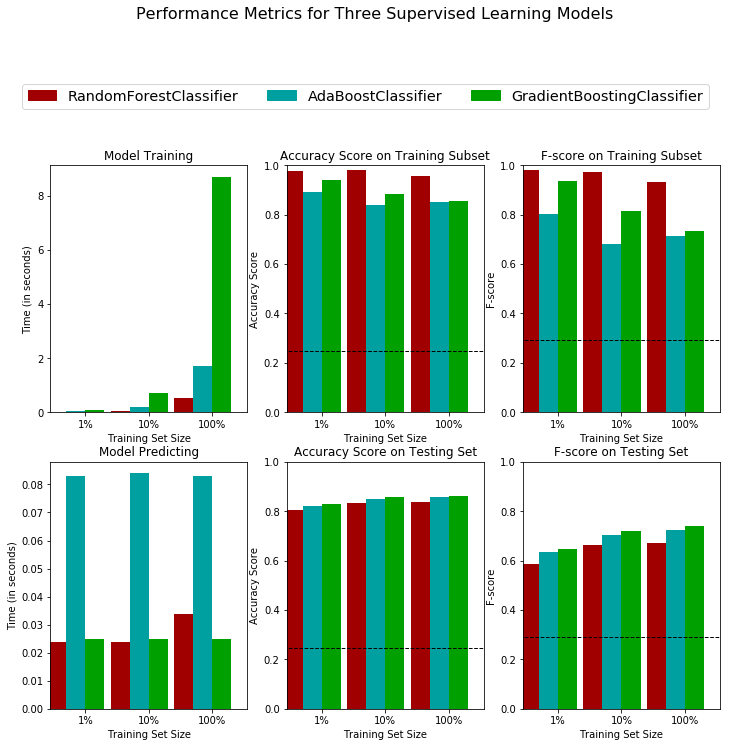

In [15]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=0)
clf_B = AdaBoostClassifier(random_state=0)
clf_C = GradientBoostingClassifier(random_state=0)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100*0.1)
samples_1 = int(samples_100*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

Based on the initial results obtained by building three Machine Learning Classifier Models using 1994 California Census data, I believe that a Gradient Boosting classifier will be the best of the three at predicting which Californians make more than $50,000 annually.  There are multiple ways to interprete the results of a Machine Learning classifier which include but Accuracy, Precision, Recall, an F1 Score and a Fb score.  Accuracy is the most straight forward as (correctly classified/total data points), but also the most misleading.  It's value can appear better or worse than it really is based on the number of positives in the total population.  As a result, we look at other metrics such as Recall, Precision, and Fbeta.  

Recall is another metric which can be used to gauge a classifier's perfomance.  It is not relevant for CharityML, however, because with a high value it will tell you how many positives were predicted of all the posatives in the State of California.  In laymans terms, "Did I reach everyone who is making \\$50,000?"  While somewhat important, it's more important to prevent sending requests to people who don't make at lease \$50,000 anually.  A high value of Precision will allow you to do this.  Precision is the way to measure how many correct positive classifications were present in a population of predicted positive classifications (P = True positives/(All Predicted Positives)).  This metric is appropriate for CharityML because it will save you money on postage.  The metric which I used to select the best model is called the Fbeta score.  It's a weighted metric that takes both Precision and Recall into account, but based on your use case gives more precedence to Precision than Recall.  I accomplish this by assigning the weight (beta value) to be 0.5.  If I instead wanted to give more precedence to Recall, then I would have assigned a beta value of 2 or higher.  Of the three models initially screened, The Gradient Boosting Classifier gave the best Fbeta score on the testing data set.  This can be seen in the bottom right plot above.  The Fbeta score on the full test data set was 0.74.   This is the highest of the three candidates, and is a reasonable score.

The training time for this model was 7.74 seconds on the full data set.  This is significant, relative to the other classifier model candidates.  However, given the task at hand this is in the noise when considering the money that will be saved by not sending mailers to improper donation candidates.  

The gradient boosting algorithm is suitable for this data set because it 'learns' with each training iteration from the mistakes of the prior Ensemble model.  Instead of just averaging them all, it gets better as it goes.  It can handle both regression for your continuous variables, and classification for your categorical variables.  Those considerations make the Gradient Boosing Classifier the Model of Choice for this CharityML project.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

The Gradient Boost Classifier Model is what's called an Ensemble Classifier Model.  Ensemble means that multiple classifier models are "Daisy Chained" together to get a better result than if you were using any one of them individually.  The Gradient boost algo uses individual 'Decision Tree' classifiers to iteratively compute its final result.  A decision tree is effectively a 'flow chart' of decisions that need to be made to arrive at a final conclusion for a given data point (person).  For example, in the case of CharityML, "Is the person male or female?"  OK, then "What does the person do for work?", etc. These decision trees eventually guide the computer to a decision about whether that person makes more than \\$50,000 annually.  The method of creating a decision tree classifier is to create internal boundaries, so that new unlabeled data can be input (with an unknown salary) and salary predicted based on those input values.  

In the case of the Gradient Boost algorithm, these individual decision tree classifiers are called 'Weak learners'.  They are weak because any one of them is only marginally better than a random guess.  One weak learner tree might excel when considering marital status, but be bad at age, and education level.  Another may excel at relationship status, but be bad at race, and capital gains.  These would be examples of 'Good' weak learners.  Another weak learner may be just 'ok' at all attributes, but great at none.  This is an example of a 'Bad' weak learner.  What makes them good or bad is in the ability of the algorithm to assign each a specific task.  For instance, with good weak learners, one would be the classifier that considers marital status, while the next considers relationship stataus.  In reality, they're considering all features, however those specific features at which they excel carry a lot more weight with those specific classifiers.  In the case of bad weak learners, none of thier considerations will carry much weight.  In the end all weak learners get a 'Vote' in the formation of the final classifier, but because of the weights each carry, the successful predictors will win out for each attribute, and the final Gradient Boost product will be better than the sum of it's parts.  

This briefly described how we 'Train' the Gradient Boost classifier.  With that classifier, we will apply it to the Census data for the entire State of California.  The classifier will look at the various input variables for each person, and will predict how much that person makes anually.  With that information, CharityML will be able to send mailers requesting donations only to people who fit the criteria for a 'Good' potential donor (eg. Make more than \\$50,000 annually) and won't need to waste effort on dead ends.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [16]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'max_depth':[2,3,4],'learning_rate':[0.5,0.1,0.01],'n_estimators':[50,100,250]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8681
Final F-score on the testing data: 0.7476


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8630      |      0.8681     |
| F-score        |       0.7395      |      0.7476     |


**Answer: **

In the case of both the Accuracy Score and The Fbeta Score, both were improved post optimization relative to the Unoptimized model.  While the optimized model is Marginally better than the Unoptimized model, it is a Significant improvement over the naive predictor from question 1.  The naive predictor had an Accuracy of 0.2478, and an Fbeta score of 0.2917.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**
 
Based on my own knowledge, I'd assume that the five most important features in the CharityML dataset for predicting Annual Salary would be (in order from greatest contribution to lease):

education_level, occupation, workclass, relationship, sex

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

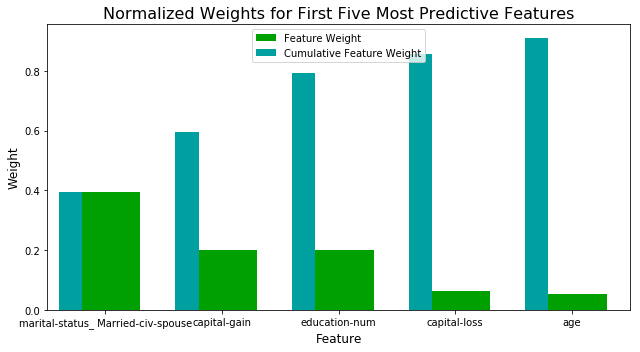

In [17]:
# TODO: Import a supervised learning model that has 'feature_importances_'
%matplotlib inline

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
Of the five features I selected, none were selected by feature_importances_.  This goes to show that the problem at hand is non-intuitive.  My choice of 'Relationship' is similar to 'Marital-Status' in motivation, however, it appears that more information is gleaned from the later.  Additionally, my choice of 'education level' is similar to 'education-num'.  Once again it appears that more information can be gleaned from education number.  Capital gain and Capial loss immediately imply a salary higher than $50,000, however I decided that this would cover a significantly small part of the data set as to not be in the top 5.  In retrospect, this was a bad assumption.  

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [18]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8681
F-score on testing data: 0.7476

Final Model trained on reduced data
------
Accuracy on testing data: 0.8593
F-score on testing data: 0.7273


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

The Accuracy and Fbeta scores were only marginally less good than the initial model build from all features.  The time on the other hand is significantly improved.  Given the right circumstance, I would choose the smaller feature set to save time and to avoid the potential to overfit the model. With this project, however, dimensionality reduction does not reveal the prior presence of overfitting, and the money saved on mail with correct classification far outweights the extra time that may be taken to predict salaries for the entire state.  So, no, in this case, I would not use the reduced feature set.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### or use...

In [19]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors-Copy1.ipynb to html',
 '[NbConvertApp] Writing 543057 bytes to finding_donors-Copy1.html',
 '[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 521887 bytes to finding_donors.html']